(basics-algorithms)=
# Algorithms

This chapter is substantially more advanced than the previous ones. It constitutes a rather big leap in difficulty too. But do not worry, we still will try to make it as accessible as possible. And if everything is not 100% chapter at first read it is no big deal, too. In this chapter we talk about **algorithms** - an absolutely essential topic to be aware when doing computational science and efficient data science. Indeed algorithms are everywhere. They are critical for science. For example, a lot of statistical methods rely on certain algorithms. But more on this later. One could even go so far to say they are every in real life!
Think of an **algorithm** like a **cooking recipe**: clear steps, in the right order, that scale when you cook for more people (bigger datasets). In this chapter we keep it practical and beginner-friendly. We do not attempt to give a comprehensive introduction to algorithms like computer science majors would. We focus on **searching** and **matching** in **country** datasets (energy per capita, emissions per capita), and how to avoid slow nested loops. We only use the following libraries **NumPy, pandas, and Matplotlib**.

:::{tip}
**You will learn**
- What an *algorithm* is (recipe for data tasks).
- Big-O complexity as **growth shapes** (not proofs).
- Why nested `for` loops get slow and how to avoid them.
- Faster patterns: `.isin`, boolean masks, `merge`, `groupby`.
- What **masks** are (boolean arrays) and how they relate to **0/1 arrays**.
- How to **measure runtime** and **plot scaling** with NumPy/Pandas/Matplotlib.
:::

---

## 1) Algorithms as recipes & the Big-O intuition

- A **good recipe** is clear, repeatable, and scales for 4, 40, or 400 guests.  
- A **good algorithm** is the same: clear steps, easy to check, and fast enough as your data grows.

One important to thing about algorithms to learn is how fast, or slow, they run. In computer science, this is often introduced alongside the so called Big-O notation. Big-O stands here for "order of growth" and growth refers usually to the growth in time it takes for the algorithm to complete. We do not need to understand this very deeply, but the key point is that one can express how algorithms' time to complete increases as a function of their input. 

### Start with functions you know: linear vs. quadratic vs. logarithmic

From high-school math, you’ve seen different **growth functions**:

- **Linear:** \(f(n)=an+b\). If you double \(n\), the output roughly doubles.  
  Example: counting countries once → **one pass** through the table.
- **Quadratic:** \(g(n)=cn^2\). If you double \(n\), output **quadruples**.  
  Example: comparing **all pairs** of countries (nested loop over the same list).
- **Logarithmic:** \(h(n)=d\log_2 n\). If you double \(n\), output only grows by an **additive constant**.  
  Example: **binary search** that halves the search range each step.

These functions explain **why some algorithms stay fast** as your dataset grows and others blow up quickly.

:::{admonition} Intuition check
- Linear work: cook 1 portion per guest → 4 guests ≈ 4 portions → **manageable**.  
- Quadratic work: every guest shakes hands with every other guest → pairs explode as group grows → **gets slow**.  
- Logarithmic work: halving the problem repeatedly → **very efficient**.
:::

### A tiny table of growth (units are abstract “work”)

| n   | \(\log_2 n\) | \(n\) | \(n \log_2 n\) | \(n^2\) |
|-----|--------------:|------:|---------------:|--------:|
| 100 |           6.6 |   100 |            660 |   10,000 |
| 1k  |           10  |  1,000|         10,000 |  1,000,000 |
| 10k |           13.3| 10,000|        133,000 | 100,000,000 |

Going from 1k to 10k rows, **linear** work increases ×10, but **quadratic** work increases ×100. That is the heart of Big-O.

### Big-O (growth shapes) overview

You might see the following notation in the computer science or programming literature.

- **O(1)** constant time (like picking a spice from a labeled jar)
- **O(log n)** slow growth (binary search)
- **O(n)** one pass (filtering rows)
- **O(n log n)** efficient sorts/joins (common, scales well)
- **O(n²)** all pairs; nested loops over the same data (gets costly)
- **O(n³)** triple loops (usually too slow at scale)



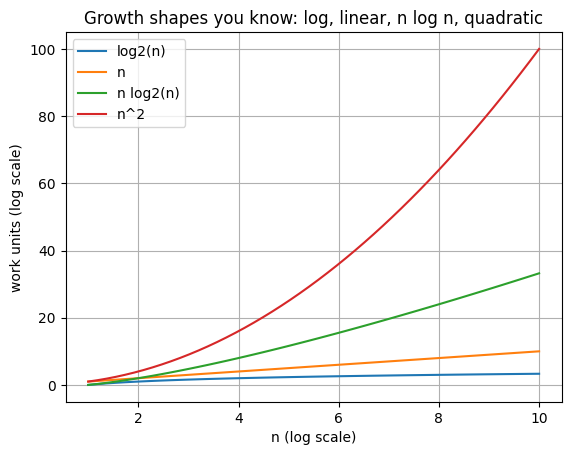

In [1]:
# Optional: plot these growth shapes to "see" the difference
import numpy as np
import matplotlib.pyplot as plt

n = np.linspace(1, 10, 50)  # 1e2 ... 1e4
f_log = np.log2(n)
f_lin = n
f_nlogn = n * np.log2(n)
f_quad = n**2

plt.figure()
plt.plot(n, f_log, label="log2(n)")
plt.plot(n, f_lin, label="n")
plt.plot(n, f_nlogn, label="n log2(n)")
plt.plot(n, f_quad, label="n^2")
plt.xlabel("n (log scale)")
plt.ylabel("work units (log scale)")
plt.title("Growth shapes you know: log, linear, n log n, quadratic")
plt.legend()
plt.grid(True)
plt.show()

:::{admonition} Rule of thumb
Each extra nested loop over big data often **multiplies** your runtime. Prefer vectorization, hashing (sets/dicts), joins, and indexing.
:::

---

## 2) Masks: the Swiss‑army knife of filtering

A **mask** is a boolean array (`True`/`False`) that marks which rows you want. In NumPy/Pandas:
- `True` = keep the row
- `False` = drop the row

Masks combine with `&` (and), `|` (or), `~` (not). Booleans behave like **0/1** under the hood, and you can convert explicitly with `.astype(int)`.

In [2]:
import numpy as np
import pandas as pd

arr = np.array([3, 7, 2, 9, 5])
mask = arr > 5           # boolean mask
print("mask:", mask)

mask01 = mask.astype(int)  # 1 for True, 0 for False
print("mask as 0/1:", mask01)

print("filtered:", arr[mask])

mask: [False  True False  True False]
mask as 0/1: [0 1 0 1 0]
filtered: [7 9]


**Why masks matter:** Many slow `for` loops can be replaced by building a smart mask once and applying it all in efficient, low‑level C code inside NumPy/Pandas.

---

## 3) Country data: energy & emissions per capita

We’ll synthesize simple country panel data. This is fake data! For training purposes.
- `energy_pc_GJ` (GJ per person)
- `emiss_pc_tCO2` (tons CO₂ per person)
- `region` and `year` for grouping and joining tasks

Just run the following code.

**Why masks matter:** Many slow `for` loops can be replaced by building a smart mask once and applying it all in efficient, low‑level C code inside NumPy/Pandas.

---

## 3) Country data: energy & emissions per capita

We’ll synthesize simple country panel data. This is fake data! For training purposes.
- `energy_pc_GJ` (GJ per person)
- `emiss_pc_tCO2` (tons CO₂ per person)
- `region` and `year` for grouping and joining tasks

Just run the following code.

In [3]:
import random
import pandas as pd

def make_countries_panel(n_countries=80, years=range(2005, 2016)):
    rng = random.Random(42)
    countries = [f"CTY{i:03d}" for i in range(n_countries)]
    regions = ["Europe","Asia","Africa","Americas","Oceania"]
    rows = []
    for c in countries:
        region = rng.choice(regions)
        base_energy = rng.uniform(30, 200)  # GJ per capita baseline
        base_emiss  = rng.uniform(1.5, 20)  # tCO2 per capita baseline
        for y in years:
            # gentle trends/variation
            e = base_energy * (1 + 0.01*(y - years.start)) + rng.uniform(-5, 5)
            m = base_emiss  * (1 + 0.005*(y - years.start)) + rng.uniform(-1, 1)
            rows.append({
                "country": c,
                "region": region,
                "year": y,
                "energy_pc_GJ": max(0.0, e),
                "emiss_pc_tCO2": max(0.0, m),
            })
    return pd.DataFrame(rows)

countries = make_countries_panel(n_countries=120, years=range(2008, 2020))
countries.head()

,country,region,year,energy_pc_GJ,emiss_pc_tCO2
0,CTY000,Europe,2008,31.483936,7.060985
1,CTY000,Europe,2009,36.361342,7.405342
2,CTY000,Europe,2010,30.806253,6.497766
3,CTY000,Europe,2011,30.577355,6.124139
4,CTY000,Europe,2012,35.675454,5.772875


## 2) One concrete task

**Goal:** Select countries in `["Europe","Americas"]` **with** `energy_pc_GJ > 150` from the dataframe we created above.

We’ll do it **twice**:
1) a **double loop** (slow/illustrative), and  
2) a **single boolean mask** (fast & simple).

### 2.1 Double loop (illustrative baseline)


In [4]:
target_regions = ["Europe", "Americas"]
energy_threshold = 150.0

def slow_filter_double_loop(countries, regions, thr):
    out = []
    for row in countries.itertuples(index=False):
        # inner membership "loop" via 'in' over a Python list (illustrative)
        for r in regions:
            if (row.region == r) and (row.energy_pc_GJ > thr):
                out.append(row)
                break  # found a match; stop scanning regions
    return pd.DataFrame(out, columns=countries.columns)

slow_result = slow_filter_double_loop(countries, target_regions, energy_threshold)
slow_result.head()

,country,region,year,energy_pc_GJ,emiss_pc_tCO2
0,CTY005,Europe,2008,159.204136,16.661843
1,CTY005,Europe,2009,152.226139,16.998914
2,CTY005,Europe,2010,161.981264,16.092648
3,CTY005,Europe,2011,159.333758,17.058564
4,CTY005,Europe,2012,165.244892,17.786186


### 2.2 Boolean mask (recommended)

In [5]:
def fast_filter_mask(countries, regions, thr):
    mask = countries["region"].isin(regions) & (countries["energy_pc_GJ"] > thr)
    return countries.loc[mask]

fast_result = fast_filter_mask(countries, target_regions, energy_threshold)
fast_result.head()

,country,region,year,energy_pc_GJ,emiss_pc_tCO2
60,CTY005,Europe,2008,159.204136,16.661843
61,CTY005,Europe,2009,152.226139,16.998914
62,CTY005,Europe,2010,161.981264,16.092648
63,CTY005,Europe,2011,159.333758,17.058564
64,CTY005,Europe,2012,165.244892,17.786186


### 2.3 Check they are the same rows (sanity)

In [6]:
# Sort and compare by a stable key (country, year) to avoid order effects
cmp_cols = ["country","year","region","energy_pc_GJ","emiss_pc_tCO2"]
same = slow_result.sort_values(cmp_cols).reset_index(drop=True).equals(
       fast_result.sort_values(cmp_cols).reset_index(drop=True)
)
same

True


### 2.4 Quick timing

In [7]:
%timeit -n1 -r3 slow_filter_double_loop(countries, target_regions, energy_threshold)
%timeit -n1 -r3 fast_filter_mask(countries, target_regions, energy_threshold)

1.56 ms ± 208 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
525 µs ± 263 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)



**Takeaway:** Replace “scan‑inside‑a‑scan” with **one mask**. It’s shorter, clearer, and usually much faster.

---

## 3) (Optional) Mask as 0/1

Sometimes you want to *see* or aggregate the mask numerically.

In [8]:
mask = countries["region"].isin(target_regions) & (countries["energy_pc_GJ"] > energy_threshold)
mask.head().astype(int)  # 1 where row passes, 0 otherwise

0    0
1    0
2    0
3    0
4    0
dtype: int32

---

## 4) Short exercise

**Exercise.** Modify the task so that **both** conditions must hold:
- `region` is in `["Europe","Asia"]`
- `emiss_pc_tCO2 > 8`

1) Write an **(illustrative) double loop** solution.  
2) Replace it with **one mask**.  
3) Confirm both results are identical (as in §2.3) and time them (as in §2.4).

In [9]:
# double loop
def slow_eu_asia_high_emiss(countries):
    out = []
    targets = ["Europe","Asia"]
    for row in countries.itertuples(index=False):
        for r in targets:
            if (row.region == r) and (row.emiss_pc_tCO2 > 8):
                out.append(row); break
    return pd.DataFrame(out, columns=countries.columns)

# mask
fast = countries[countries["region"].isin(["Europe","Asia"]) & (countries["emiss_pc_tCO2"] > 8)]

## 5) Tiny cheat‑sheet

| Task | Slow pattern | Fast pattern |
|---|---|---|
| Filter on conditions | Double loop over rows & targets | One **mask** with `.isin` and comparisons |
| Check results match | — | Sort on key columns and `.equals(...)` |
| Compare speed | Manual timing | `%timeit` |
